In [1]:
import numpy as np
import tensorflow as tf
import keras
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from keras import layers, optimizers, losses, metrics, preprocessing, utils, callbacks, models
from keras.saving import register_keras_serializable
from sklearn.metrics import confusion_matrix

In [2]:
# Augmentation layer
@register_keras_serializable()
class RandomRotationLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(RandomRotationLayer, self).__init__(**kwargs)

    def call(self, inputs, training=False):
        if training:
            # Choose a random integer from 0 to 3
            k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
            # Apply rotation
            return tf.image.rot90(inputs, k=k)
        else:
            # Return the input unchanged during inference
            return inputs

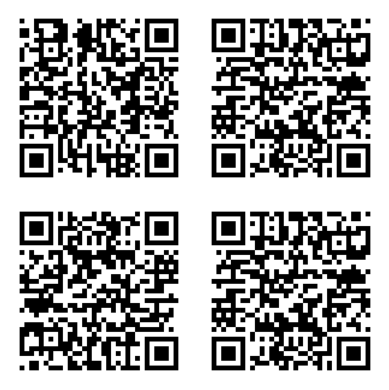

In [3]:
# Create an instance of the custom layer
rotation_layer = RandomRotationLayer()

# Load and prepare the image
img_path = "/kaggle/input/benign-and-malicious-qr-codes/QR codes/benign/benign/benign_0.png"
img = keras.preprocessing.image.load_img(img_path)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Apply the custom layer
fig, axes = plt.subplots(2, 2, figsize=(4, 4))
for ax, _ in zip(axes.flatten(), range(4)):
    rotated_image_tensor = rotation_layer(tf.convert_to_tensor(img_array, dtype=tf.float32), training=True)
    rotated_image = rotated_image_tensor.numpy()[0].astype(np.uint8)
    ax.imshow(rotated_image)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [4]:
img_size = img.size
print(img_size)

(370, 370)


In [5]:
# Directory paths using raw strings
data_dir = r"/kaggle/input/benign-and-malicious-qr-codes/QR codes"

def load_datasets(batch_size=16, validation_split=0.2):
    # train data
    train_data = preprocessing.image_dataset_from_directory(
        data_dir,
        subset="training",
        image_size=(50, 50),
        label_mode='int',
        batch_size=batch_size,
        validation_split=validation_split,
        shuffle=True,
        seed=123,
    )
    
    # Validation data
    val_data = preprocessing.image_dataset_from_directory(
        data_dir,
        subset="validation",
        image_size=(50, 50),
        label_mode='int',
        batch_size=batch_size,
        validation_split=validation_split,
        shuffle=True,
        seed=123,
    )

    return train_data, val_data

# Load datasets
train_data, val_data = load_datasets(batch_size=8, validation_split=0.2)

Found 200000 files belonging to 2 classes.
Using 160000 files for training.
Found 200000 files belonging to 2 classes.
Using 40000 files for validation.


In [6]:
# Inspect the datasets
class_names = train_data.class_names
print(class_names)

for image_batch, label_batch in train_data.take(1):
    print("Training image batch shape:", image_batch.shape)
    print("Training label batch shape:", label_batch.shape)
    
for image_batch, label_batch in val_data.take(1):
    print("Validation image batch shape:", image_batch.shape)
    print("Validation label batch shape:", label_batch.shape)
    
print(len(train_data))
print(len(val_data))

['benign', 'malicious']
Training image batch shape: (8, 50, 50, 3)
Training label batch shape: (8,)
Validation image batch shape: (8, 50, 50, 3)
Validation label batch shape: (8,)
20000
5000


In [7]:
# Prepare data
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# Network architecture
utils.set_random_seed(123)

# Input layer
inputs = layers.Input(shape=(50, 50, 3))

# Data augmentation
rotated = RandomRotationLayer()(inputs, training=True)
normalized = layers.Rescaling(1./255)(rotated)

# Convolutional layers
X = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same")(normalized)
X = layers.BatchNormalization()(X)
X = layers.Activation("relu")(X)
X = layers.MaxPooling2D(pool_size=(2, 2))(X)

X = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation("relu")(X)
X = layers.MaxPooling2D(pool_size=(2, 2))(X)

X = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation("relu")(X)
X = layers.MaxPooling2D(pool_size=(2, 2))(X)

# Flatten
X = layers.Flatten()(X)

# Fead forward network
X = layers.Dense(units=265)(X)
X = layers.BatchNormalization()(X)
X = layers.Activation("relu")(X)
X = layers.Dropout(0.5)(X)

X = layers.Dense(units=128)(X)
X = layers.BatchNormalization()(X)
X = layers.Activation("relu")(X)
X = layers.Dropout(0.5)(X)

# Output
outputs = layers.Dense(units=1, activation="sigmoid")(X)

# Build model
net = models.Model(inputs, outputs)

In [9]:
utils.plot_model(
    net,
    to_file="architecture.png",
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
    rankdir="TB",
    dpi=300,
)

net.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_layer_1         │ (None, 50, 50, 3)      │             0 │
│ (RandomRotationLayer)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 265)            │     1,221,385 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 265)            │         1,060 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 265)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 265)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 1,351,278 (5.15 MB)

 Trainable params: 1,350,044 (5.15 MB)

 Non-trainable params: 1,234 (4.82 KB)

In [10]:
# Custom F1 score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = metrics.Precision()
        self.recall = metrics.Recall()
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update precision and recall states
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Get precision and recall
        precision = self.precision.result()
        recall = self.recall.result()
        # Calculate F1 score
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [11]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_f1_score',
    patience=9,
    mode='max',
    restore_best_weights=True
)

check_points = (
    callbacks.ModelCheckpoint(
        filepath="net2.keras",
        monitor="val_f1_score",
        mode='max',
        save_best_only=True,
        verbose=1,
    ),
)

In [12]:
learning_rate = 0.00001
net.compile(
    optimizer=optimizers.RMSprop(learning_rate=learning_rate),
    loss=losses.BinaryCrossentropy(from_logits=False),
    metrics=[
        metrics.BinaryAccuracy(threshold=0.5, name="accuracy"),
        metrics.Precision(name="precision"),
        metrics.Recall(name="recall"),
        F1Score(name="f1_score")
    ],
)

In [13]:
epochs = 100
history = net.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[early_stopping, check_points],
)

Epoch 1/100


I0000 00:00:1726471272.770743     102 service.cc:145] XLA service 0x7958c8012580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726471272.770801     102 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1726471272.886328     102 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. functional_1_1/random_rotation_layer_1_1/random_uniform
W0000 00:00:1726471272.890258     102 assert_op.cc:38] Ignoring Assert operator functional_1_1/random_rotation_layer_1_1/rot90/Assert/AssertGuard/Assert


   23/20000 ━━━━━━━━━━━━━━━━━━━━ 2:37 8ms/step - accuracy: 0.4983 - f1_score: 0.4917 - loss: 0.8711 - precision: 0.5170 - recall: 0.4722 

I0000 00:00:1726471278.630898     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19993/20000 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6306 - f1_score: 0.6097 - loss: 0.6870 - precision: 0.6391 - recall: 0.5841
Epoch 1: val_f1_score improved from -inf to 0.90788, saving model to net2.keras
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 269s 13ms/step - accuracy: 0.6307 - f1_score: 0.6098 - loss: 0.6870 - precision: 0.6392 - recall: 0.5841 - val_accuracy: 0.9071 - val_f1_score: 0.9079 - val_loss: 0.2395 - val_precision: 0.8939 - val_recall: 0.9223
Epoch 2/100
19985/20000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8396 - f1_score: 0.8409 - loss: 0.3579 - precision: 0.8340 - recall: 0.8479
Epoch 2: val_f1_score improved from 0.90788 to 0.95496, saving model to net2.keras
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - accuracy: 0.8396 - f1_score: 0.8409 - loss: 0.3579 - precision: 0.8340 - recall: 0.8479 - val_accuracy: 0.9552 - val_f1_score: 0.9550 - val_loss: 0.1260 - val_precision: 0.9538 - val_recall: 0.9561
Epoch 3/100
19993/20000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - a

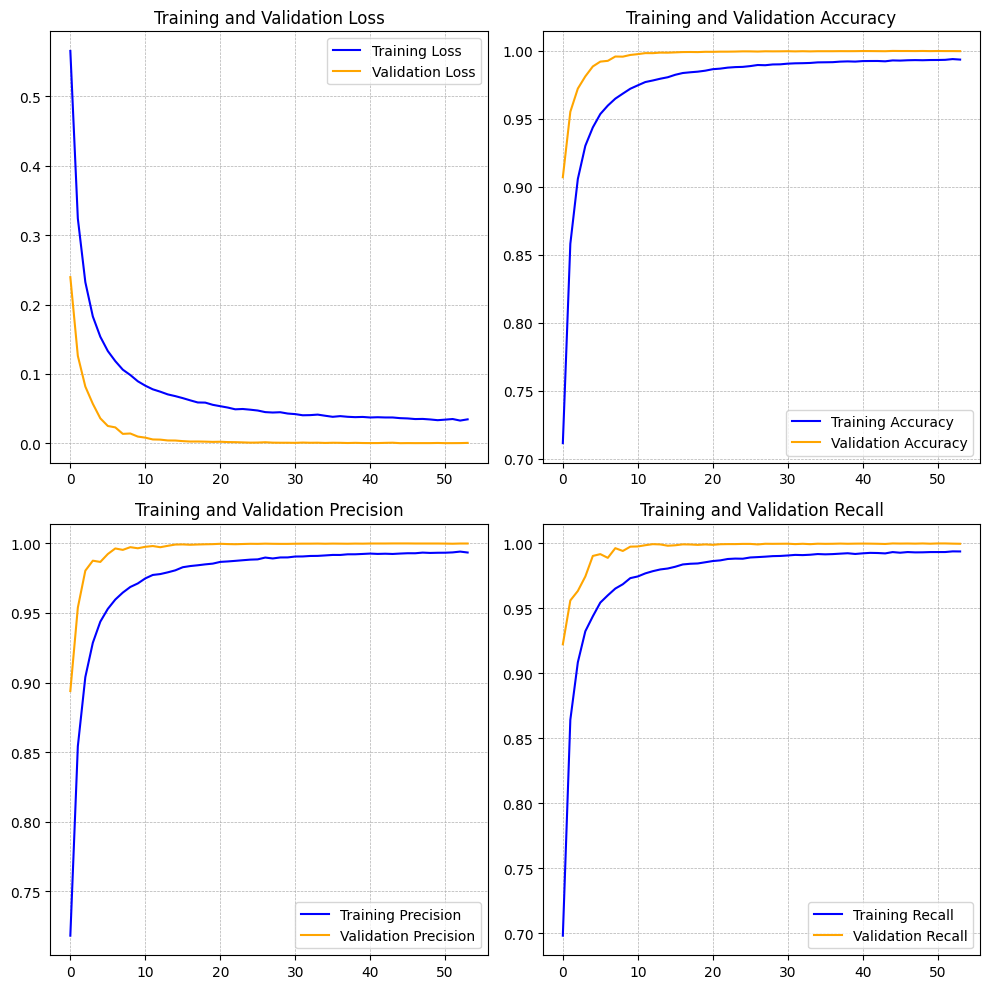

In [14]:
# Retrieve Precision and Recall values from the history
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_precision = history.history["precision"]
val_precision = history.history["val_precision"]
train_recall = history.history["recall"]
val_recall = history.history["val_recall"]

# Get the number of epochs
epochs_range = range(len(train_loss))

# Plot Training and Validation Loss
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_loss, label="Training Loss", color="blue")
plt.plot(epochs_range, val_loss, label="Validation Loss", color="orange")
plt.legend(loc="upper right")
plt.grid(True, lw=0.5, linestyle="--")
plt.title("Training and Validation Loss")

# Plot Training and Validation Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_acc, label="Training Accuracy", color="blue")
plt.plot(epochs_range, val_acc, label="Validation Accuracy", color="orange")
plt.legend(loc="lower right")
plt.grid(True, lw=0.5, linestyle="--")
plt.title("Training and Validation Accuracy")

# Plot Training and Validation Precision
plt.subplot(2, 2, 3)
plt.plot(epochs_range, train_precision, label="Training Precision", color="blue")
plt.plot(epochs_range, val_precision, label="Validation Precision", color="orange")
plt.legend(loc="lower right")
plt.grid(True, lw=0.5, linestyle="--")
plt.title("Training and Validation Precision")

# Plot Training and Validation Recall
plt.subplot(2, 2, 4)
plt.plot(epochs_range, train_recall, label="Training Recall", color="blue")
plt.plot(epochs_range, val_recall, label="Validation Recall", color="orange")
plt.legend(loc="lower right")
plt.grid(True, lw=0.5, linestyle="--")
plt.title("Training and Validation Recall")

# Save the figure and display
plt.tight_layout()
plt.savefig("metrics.png")
plt.show()

In [15]:
# Load the net
loaded_net = models.load_model(
    "net2.keras",
    custom_objects={"RandomRotationLayer": RandomRotationLayer},
)

TypeError: Could not locate class 'F1Score'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'F1Score', 'config': {'name': 'f1_score', 'dtype': 'float32'}, 'registered_name': 'F1Score'}

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


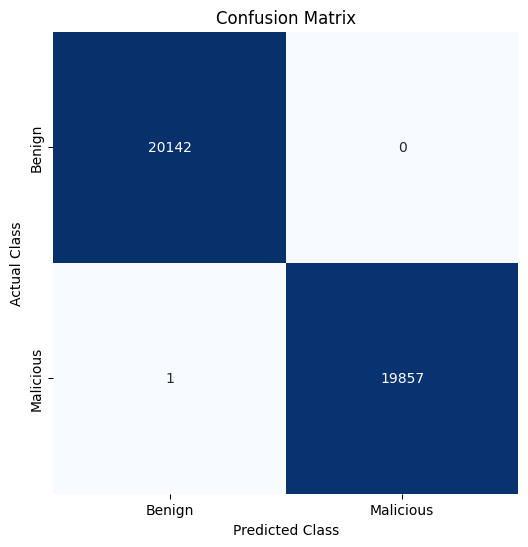

In [16]:
# Get predictions on validation data
val_labels = np.concatenate([y for x, y in val_ds], axis=0)  # True labels
val_predictions = net.predict(val_ds)  # Predictions (probabilities)

# Convert predictions to binary class labels
predicted_classes = (val_predictions > 0.5).astype("int32")  # Threshold at 0.5

# Generate the confusion matrix
cm = confusion_matrix(val_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Benign", "Malicious"],
    yticklabels=["Benign", "Malicious"],
)
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")

plt.savefig("confusion.png")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


/tmp/ipykernel_36/63663167.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = int(predicted_labels[i])


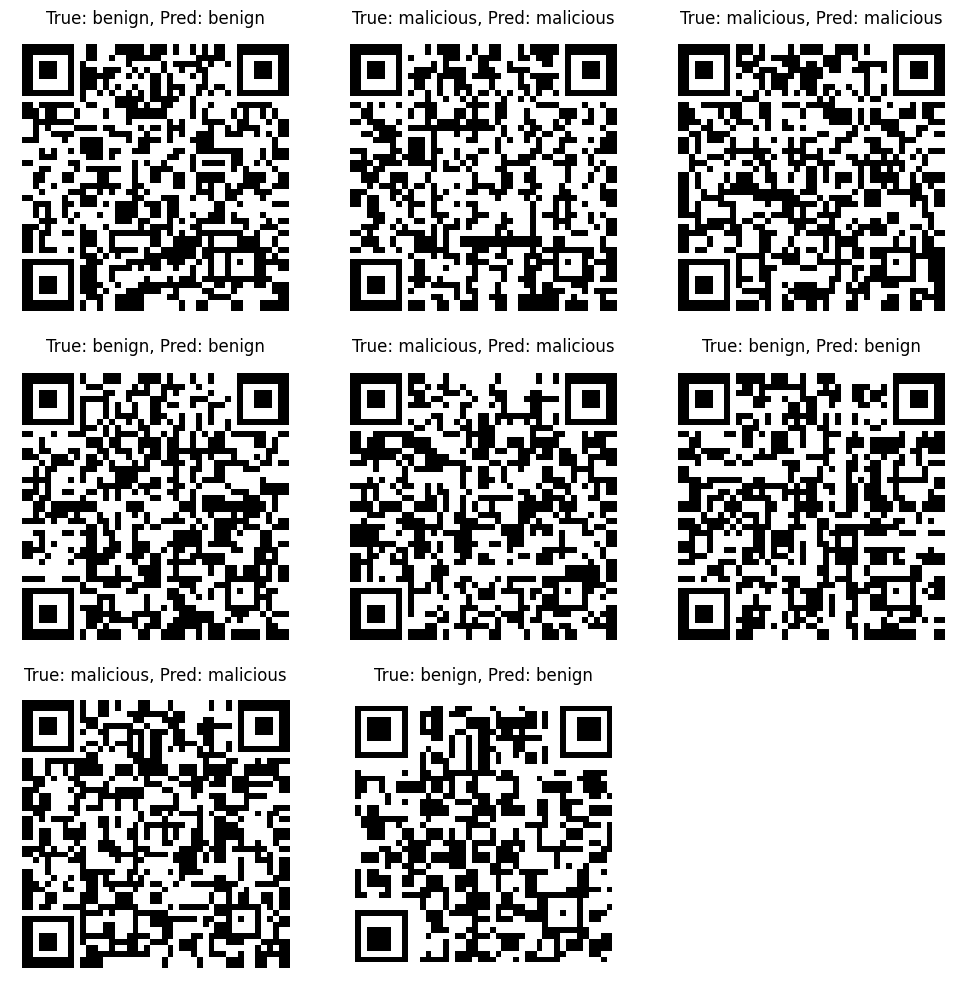

In [17]:
# Plot samples
def plot_samples_with_predictions(val_ds, model, class_names, num_samples=9):
    # Take a batch of data from the validation dataset
    val_images, val_labels = next(iter(val_ds))  # Take one batch

    # Ensure the batch has enough samples
    if num_samples > val_images.shape[0]:
        num_samples = val_images.shape[0]  # Adjust if batch is smaller than num_samples
        print(f"Reducing num_samples to {num_samples} as the batch size is smaller.")

    # Make predictions
    predictions = model.predict(val_images)

    # For binary classification, threshold the predictions (change this for multi-class)
    predicted_labels = np.where(predictions > 0.5, 1, 0)

    # Set up the plot (3x3 grid for 9 samples or less if the batch size is smaller)
    plt.figure(figsize=(10, 10))

    for i in range(num_samples):
        # Plot the image
        plt.subplot(3, 3, i + 1)
        plt.imshow(val_images[i].numpy().squeeze())  # Adjust if grayscale

        # Get the true and predicted labels
        true_label = int(val_labels[i].numpy())
        pred_label = int(predicted_labels[i])

        # Set the title with true and predicted class names
        plt.title(f'True: {class_names[true_label]}, Pred: {class_names[pred_label]}')
        plt.axis('off')  # Hide axis

    plt.tight_layout()
    plt.savefig("predictions.png")
    plt.show()

# Example usage assuming class_names is available
plot_samples_with_predictions(val_ds, net, class_names, num_samples=8)

In [21]:
# Evaluate the model on the validation dataset
results = net.evaluate(val_ds, verbose=1)

# Assuming the model was compiled with: loss, accuracy, precision, recall in this order
loss, accuracy, precision, recall, f1_score = results

# Print precision and recall
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 1.0000 - f1_score: 1.0000 - loss: 1.2741e-04 - precision: 1.0000 - recall: 1.0000
Loss: 0.0002
Accuracy: 1.0000
Precision: 1.0000
Recall: 0.9999
F1 Score: 1.0000
